In [4]:

import tensorflow as tf
from glob import glob as glb

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

In [6]:
tf.__version__

'2.0.0'

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [8]:
import pathlib
data_dir = '/home/frederik/flunnpy/Solutions_PNG'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*X.png')))
image_count
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['Mesh', 'P', 'Y', 'X'], dtype='<U4')

In [9]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [10]:
BATCH_SIZE = 4
IMG_HEIGHT = 300
IMG_WIDTH = 300
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)


In [11]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))


Found 4 images belonging to 4 classes.


In [76]:
imgX=tf.keras.preprocessing.image.load_img(
    data_dir/'X/No7_A_0-00_L0-11_cavity_vel_1_X.png',
    color_mode="grayscale",
    target_size=None,
    interpolation='nearest'
)
imgY=tf.keras.preprocessing.image.load_img(
    data_dir/'Y/No7_A_0-00_L0-11_cavity_vel_1_Y.png',
    color_mode="grayscale",
    target_size=None,
    interpolation='nearest'
)
imgP=tf.keras.preprocessing.image.load_img(
    data_dir/'P/No7_A_0-00_L0-11_cavity_vel_1_P.png',
    color_mode="grayscale",
    target_size=None,
    interpolation='nearest'
)

In [91]:
asdf=['test','test2']
return list(enumerate(college_years,2019)

SyntaxError: unexpected EOF while parsing (<ipython-input-91-66f0d8cd9fcb>, line 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


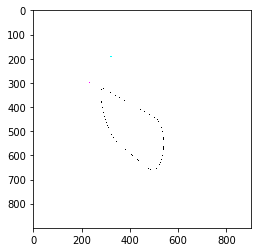

In [86]:
img_ArrX=tf.keras.preprocessing.image.img_to_array(
    imgX,
    data_format="channels_last",
    dtype=None
)
img_ArrY=tf.keras.preprocessing.image.img_to_array(
    imgY,
    data_format="channels_last",
    dtype=None
)
img_ArrP=tf.keras.preprocessing.image.img_to_array(
    imgP,
    data_format="channels_last",
    dtype=None
)
img_Arr1=np.concatenate((img_ArrX,img_ArrY,img_ArrP),axis=2)

#img_Arr1[:,:,]=img_Arr
#img_Arr1[800,800,0]
plt.imshow(img_Arr1)
#img_Arr1.shape

In [89]:
from datetime import datetime
import io
import itertools
from packaging import version
from six.moves import range

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."



# Clear out any prior log data.
!rm -rf logs

# Sets up a timestamped log directory.
logdir = "logs/train_data/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(logdir)

# Using the file writer, log the reshaped image.
with file_writer.as_default():
  tf.summary.image("Training data", img_Arr1, step=0)


TensorFlow version:  2.0.0


ValueError: .  Tensor  must have rank 4.  Received rank 3, shape (900, 900, 3)

In [73]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(4):
      ax = plt.subplot(1,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')


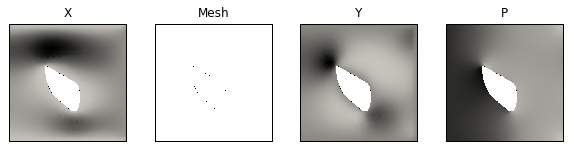

In [74]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)


In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))


In [ ]:
for f in list_ds.take(5):
  print(f.numpy())


In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=1)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [ ]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=400):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [ ]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))


In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())
